Libraries

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
import mysql.connector
from sklearn import tree

Database Connection

In [48]:
db = mysql.connector.connect(
    host="localhost",
    user="user",
    password="password",
    port="3306",
    database="realestatepredictor"
)

Prepare data

In [49]:
# Create a cursor object
cursor = db.cursor()

# Execute the query
cursor.execute("SELECT * FROM homegate")

# Fetch all the records
data = cursor.fetchall()

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['id', 'homegateid', 'price', 'rooms', 'floor', 'livingSpace', 'street', 'latitude', 'longitude', 'locality', 'postalcode'])

# Close the cursor and connection
cursor.close()
db.close()

# Handle null / empty values
df = df.dropna()

# Handle outliers using IQR method for the price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]


Visualize Data

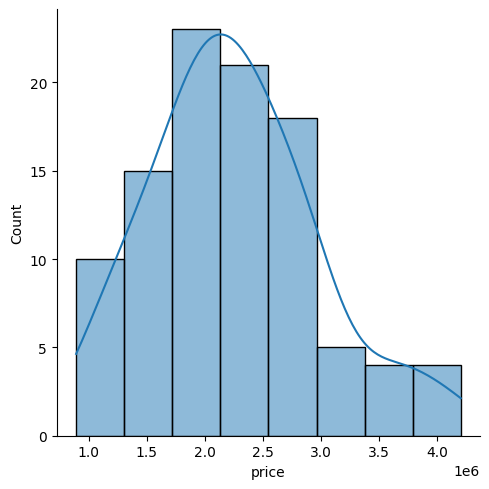

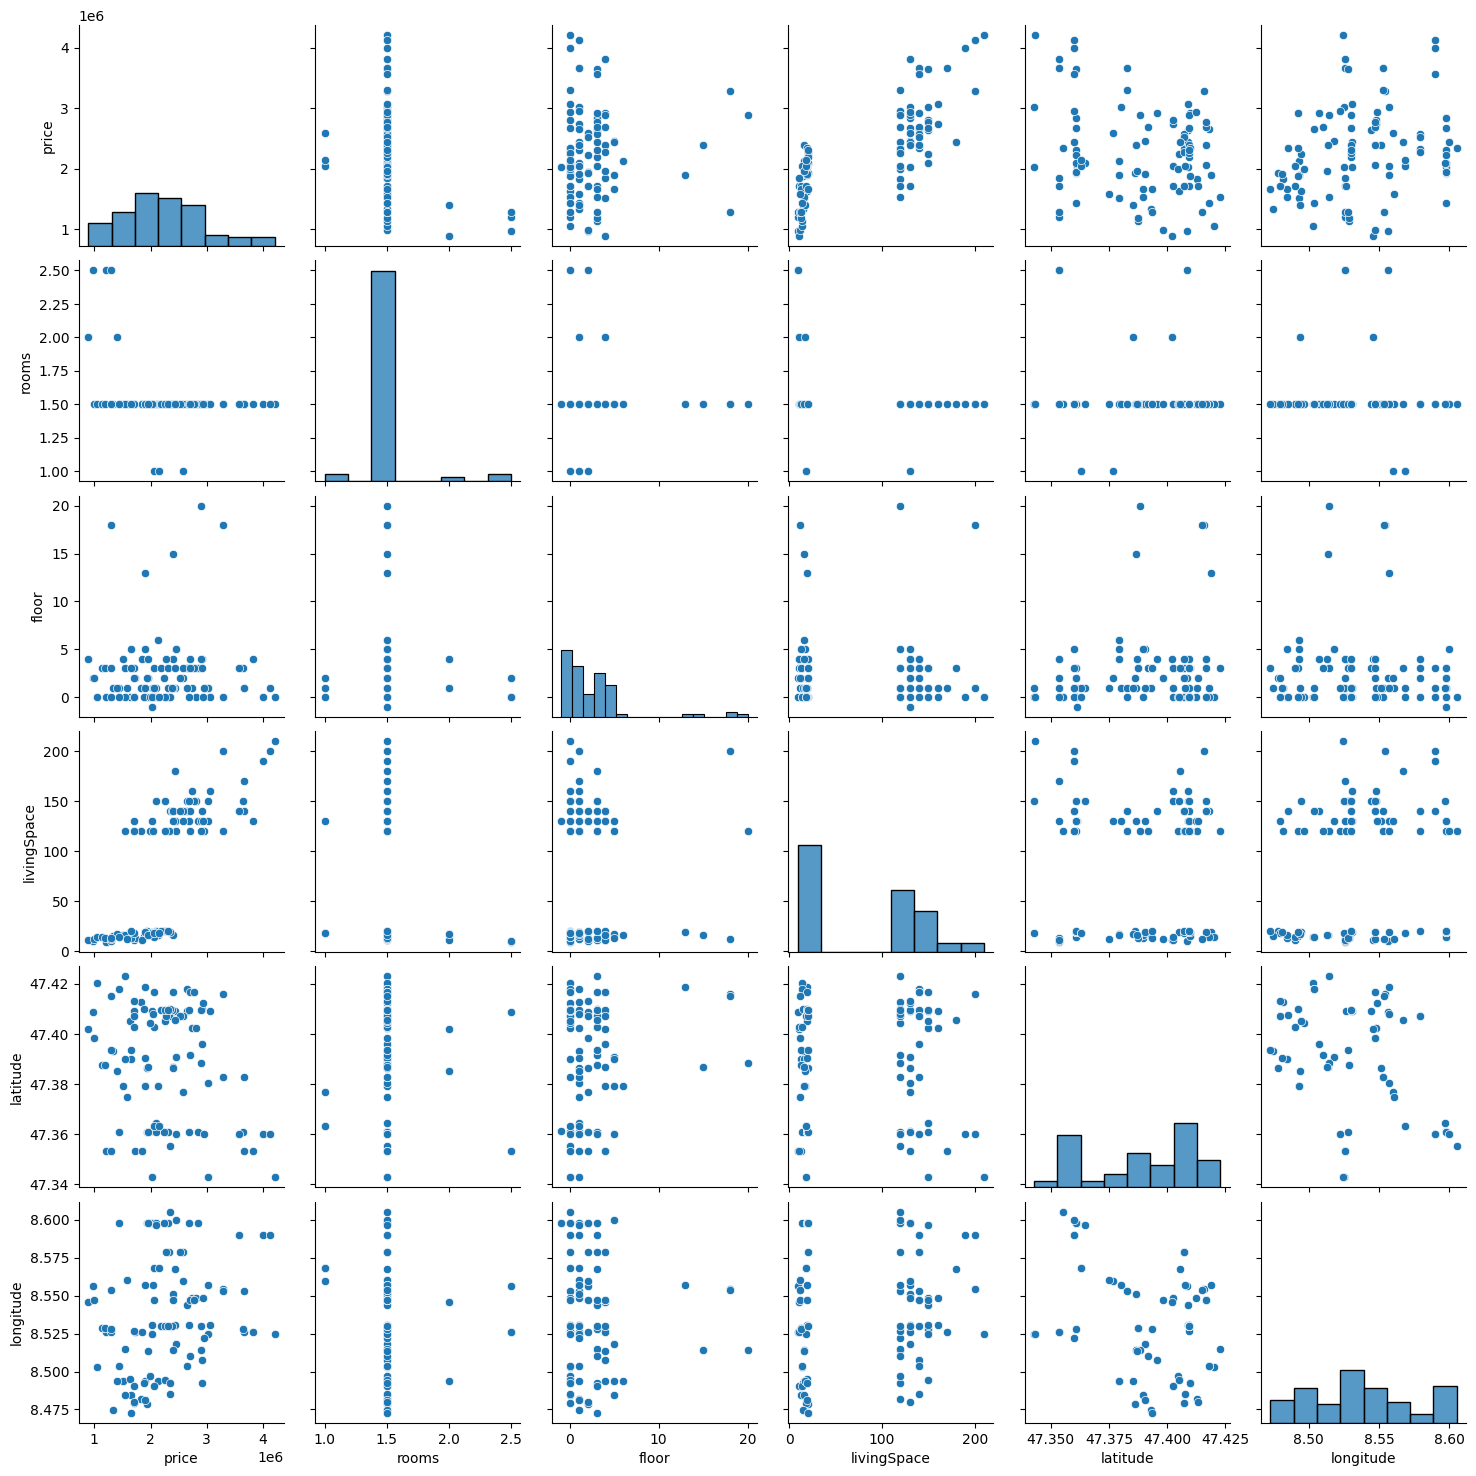

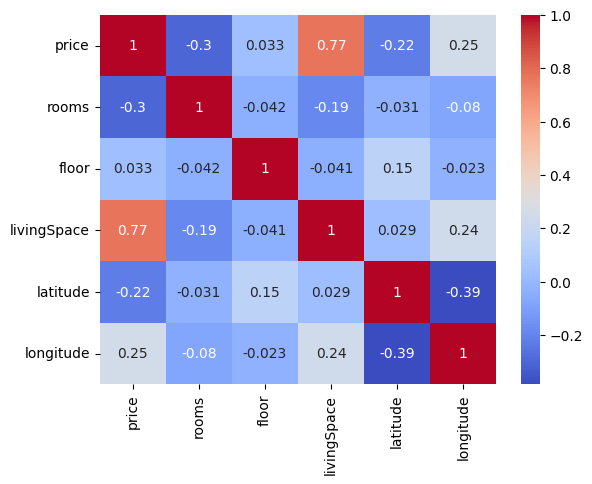

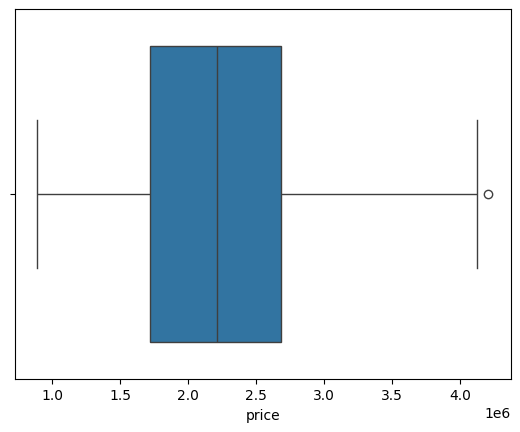

In [50]:
# Show the distribution of the different home prices
sns.displot(df['price'], kde=True)
plt.show()

# Show scatter plots to visualize the data
sns.pairplot(df[['price', 'rooms', 'floor', 'livingSpace', 'latitude', 'longitude']])
plt.show()

# Show a correlation heatmap
sns.heatmap(df[['price', 'rooms', 'floor', 'livingSpace', 'latitude', 'longitude']].corr(), annot=True, cmap='coolwarm')
plt.show()

# Visualize the boxplot for the price
sns.boxplot(x=df['price'])
plt.show()

Random Forest

In [51]:
# Prepare the data for the random forest
X = df[['rooms', 'floor', 'livingSpace', 'latitude', 'longitude']]
y = df['price']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 457702.39839212457


Random Forest Visualization

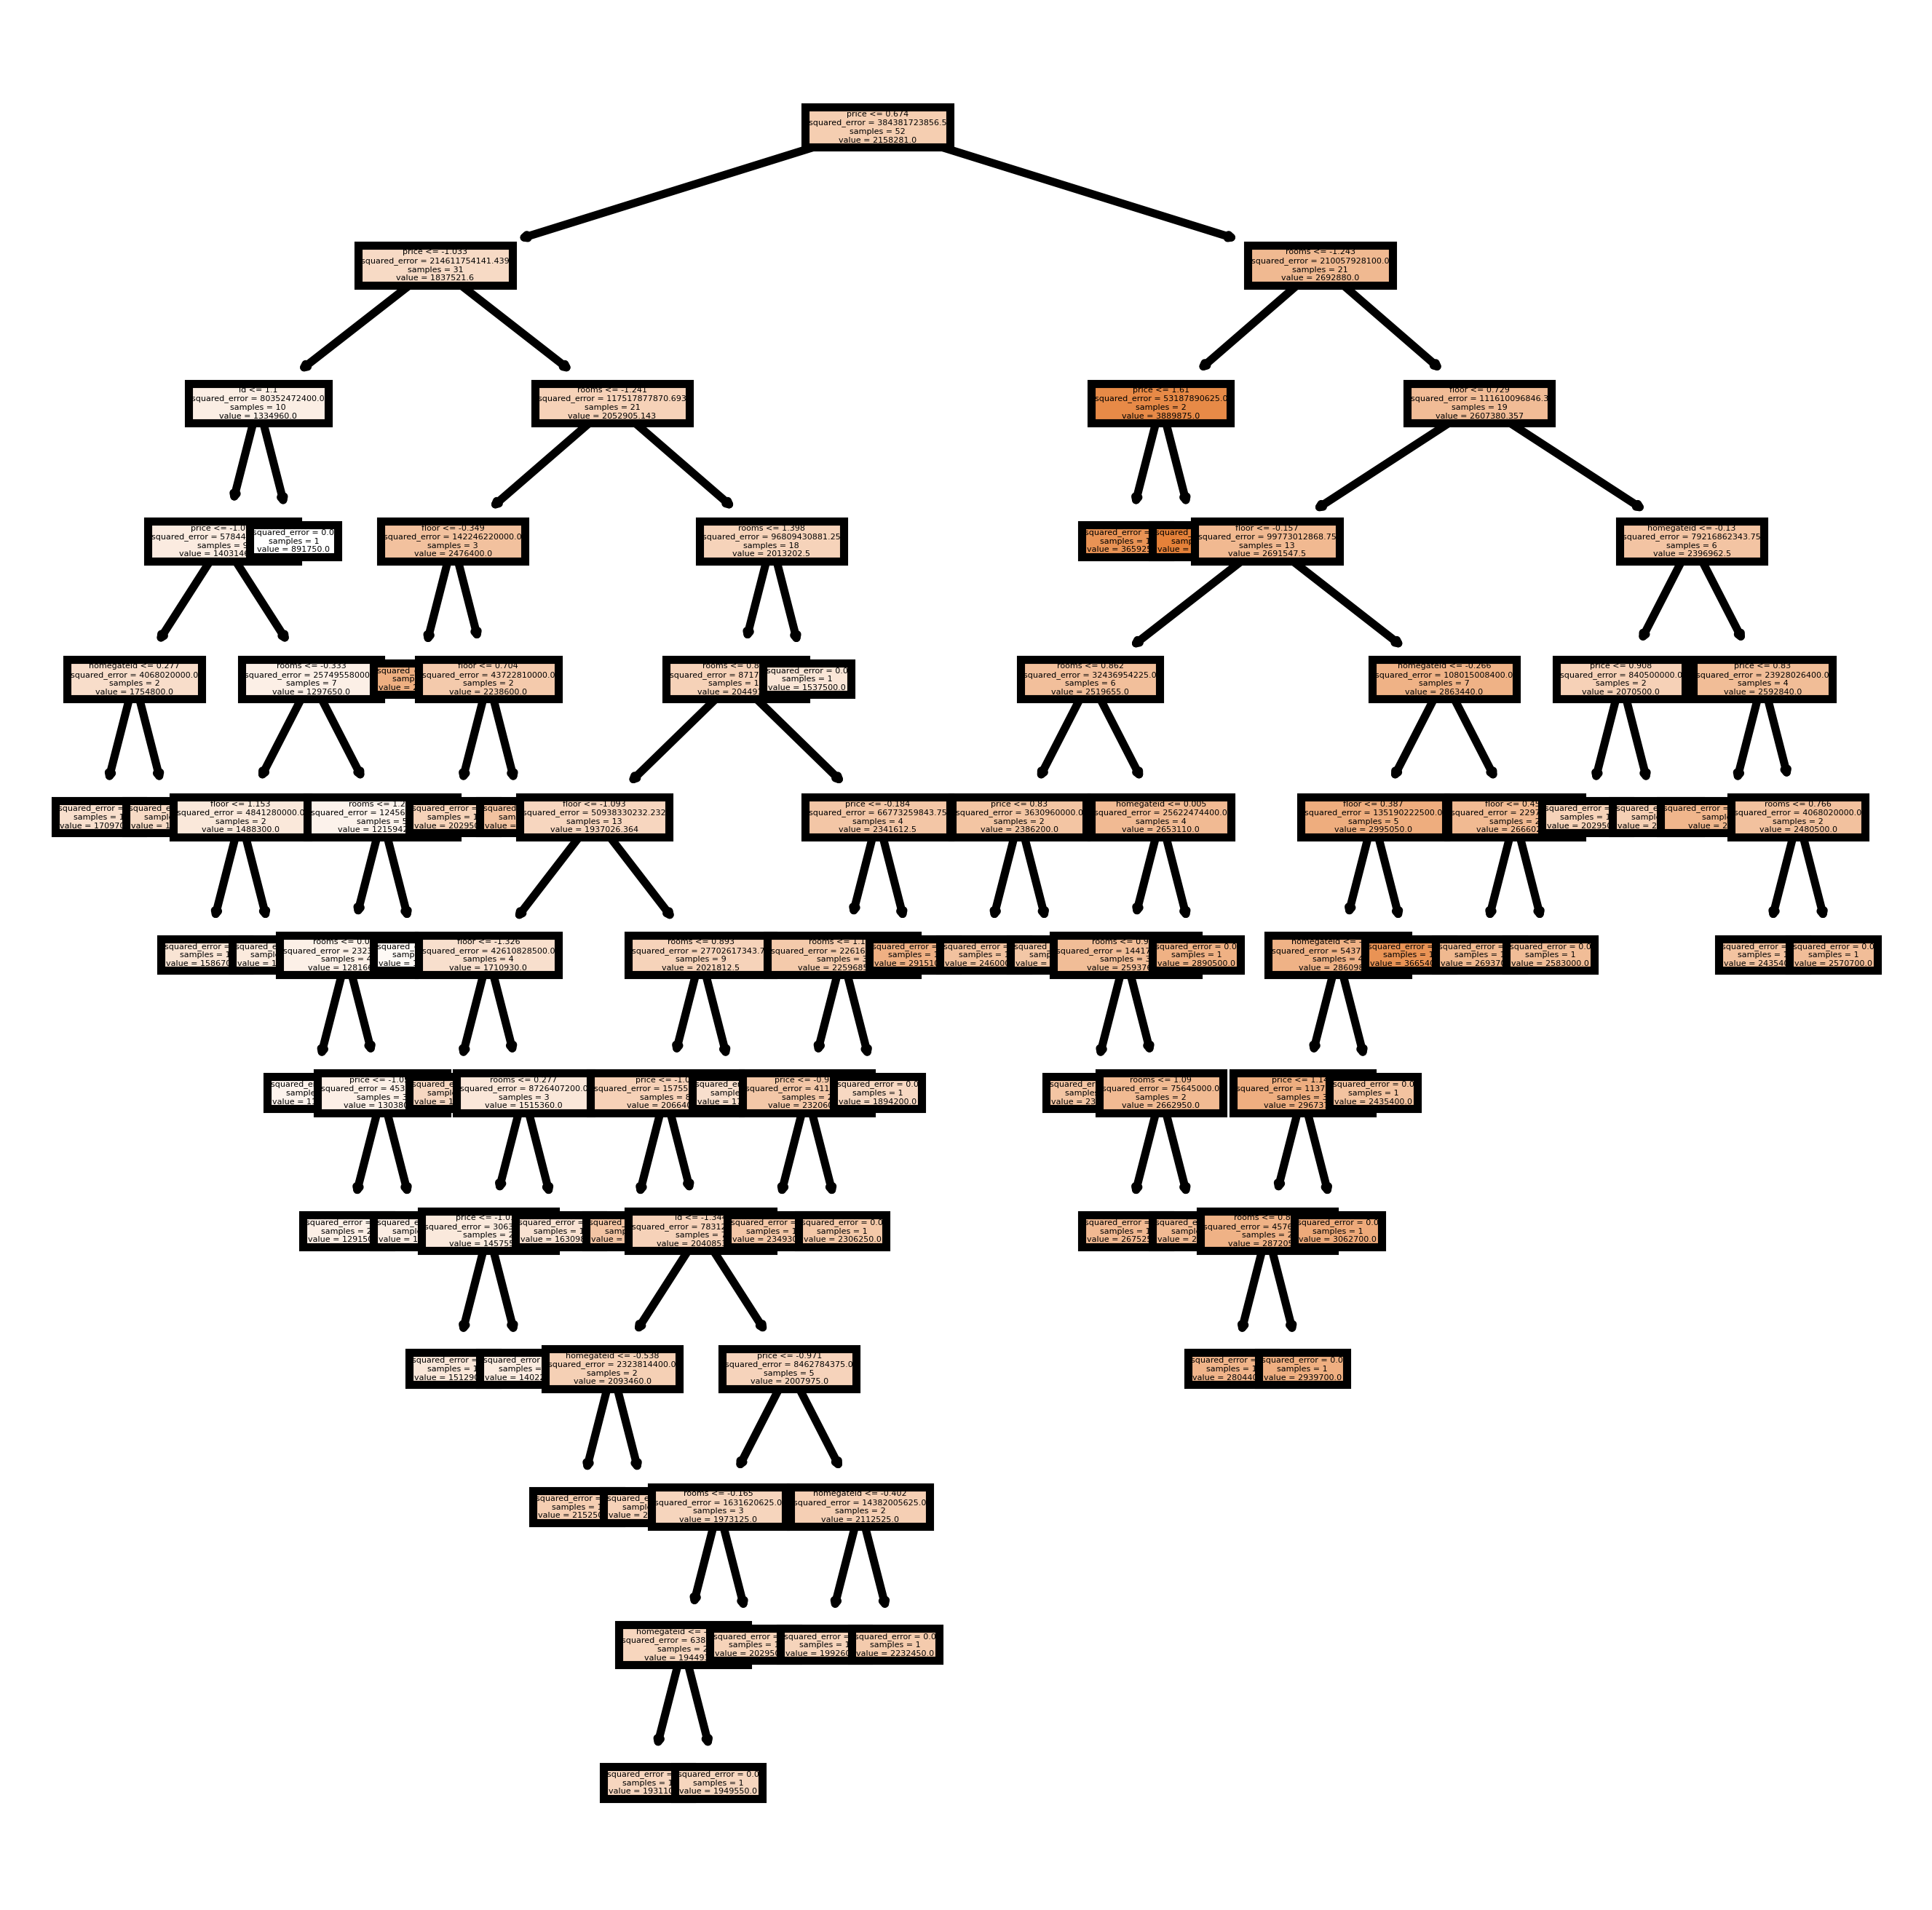

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 800)
tree.plot_tree(rf.estimators_[0], feature_names = df.columns, filled = True)
fig.savefig('rf_individualtree.png')